In [1]:
import torch
from datasets import load_dataset

In [22]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
cppe5 = load_dataset("cppe-5")

Found cached dataset cppe-5 (/root/.cache/huggingface/datasets/cppe-5/default/1.0.0/dd60c7c8210a67663b06108fb9e23c70acb98e2d3a4f3636f429509b19b74989)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [4]:
cppe5["train"][0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663 at 0x7FF79414BF50>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

In [5]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)
categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

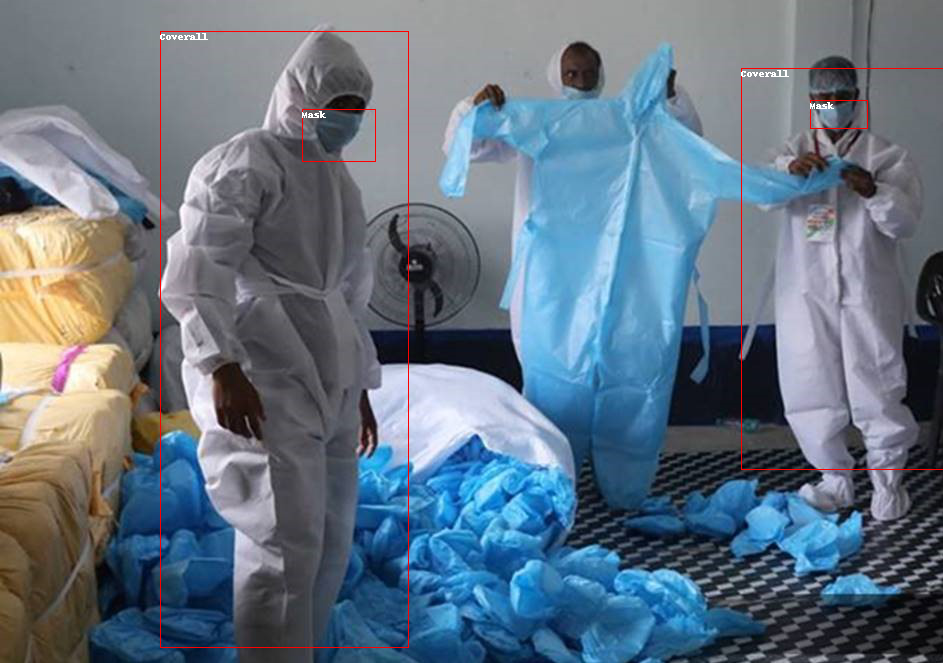

In [6]:
image

## Preprocess the data

In [23]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [24]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [25]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [26]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [27]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]

{'pixel_values': tensor([[[ 1.4440,  1.4440,  1.4440,  ..., -1.5870, -1.5870, -1.5870],
          [ 1.4440,  1.4440,  1.4440,  ..., -1.5870, -1.5870, -1.5870],
          [ 1.4440,  1.4440,  1.4440,  ..., -1.5699, -1.5699, -1.5699],
          ...,
          [-1.1589, -1.1589, -1.1589,  ..., -1.6042, -1.6042, -1.6042],
          [-1.1418, -1.1418, -1.1418,  ..., -1.6042, -1.5870, -1.5870],
          [-1.1418, -1.1418, -1.1418,  ..., -1.6042, -1.5870, -1.5870]],
 
         [[ 1.8683,  1.8683,  1.8683,  ..., -1.4405, -1.4405, -1.4405],
          [ 1.8683,  1.8683,  1.8683,  ..., -1.4405, -1.4405, -1.4405],
          [ 1.8683,  1.8683,  1.8683,  ..., -1.4230, -1.4230, -1.4230],
          ...,
          [-0.8803, -0.8803, -0.8803,  ..., -1.4580, -1.4580, -1.4580],
          [-0.8627, -0.8627, -0.8627,  ..., -1.4580, -1.4405, -1.4405],
          [-0.8627, -0.8627, -0.8627,  ..., -1.4580, -1.4405, -1.4405]],
 
         [[ 1.9777,  1.9777,  1.9777,  ..., -1.2467, -1.2467, -1.2467],
          [ 

In [28]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [42]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [45]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

trainer.train()

Cloning https://huggingface.co/susanbao/detr-resnet-50_finetuned_cppe5 into local empty directory.
/workspace/transformers/src/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
This method is deprecated and will be removed in v4.27.0. Please use pad instead.


Step,Training Loss


ValueError: Expected y_min for bbox (0.564, 1.4433333333333334, 0.659, 1.6916666666666667, 2) to be in the range [0.0, 1.0], got 1.4433333333333334.

## Evaluate

In [32]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [35]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("liuliu96/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(cppe5["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [37]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("liuliu96/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

  0%|          | 0/4 [00:00<?, ?it/s]This method is deprecated and will be removed in v4.27.0. Please use pad instead.
This method is deprecated and will be removed in v4.27.0. Please use pad instead.
This method is deprecated and will be removed in v4.27.0. Please use pad instead.
This method is deprecated and will be removed in v4.27.0. Please use pad instead.
`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
100%|██████████| 4/4 [00:43<00:00, 10.86s/it]


Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

## inference

In [38]:
from transformers import pipeline
import requests

url = "https://i.imgur.com/2lnWoly.jpg"
image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline("object-detection", model="liuliu96/detr-resnet-50_finetuned_cppe5")
obj_detector(image)

[]

In [40]:
image_processor = AutoImageProcessor.from_pretrained("liuliu96/detr-resnet-50_finetuned_cppe5")
model = AutoModelForObjectDetection.from_pretrained("liuliu96/detr-resnet-50_finetuned_cppe5")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

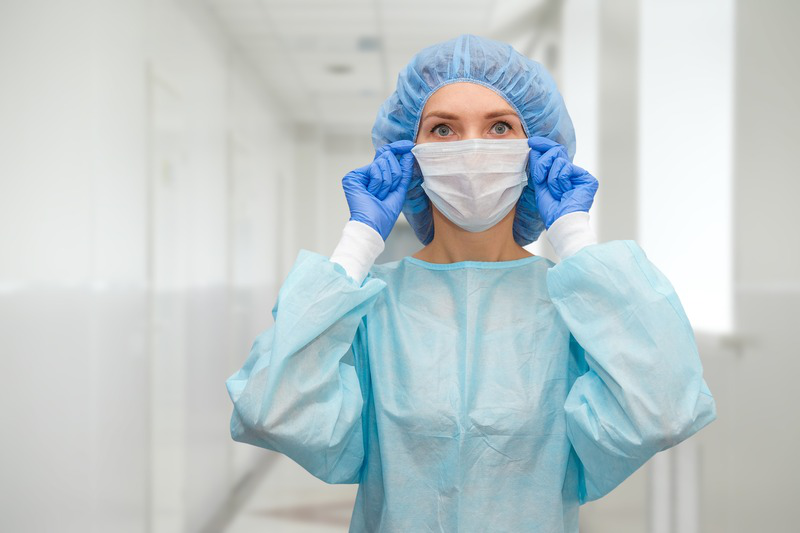

In [41]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image